# <center> WSI Ćwiczenie nr.7 - Implementacja naiwnego klasyfikatora Bayesa</center>

### <center>Maciej Łodziński</center>


### Cel ćwiczenia:
Celem ćwiczenia jest implementacja naiwnego klasyfikatora Bayesa a następnie porównanie jego metryk na podstawie zbioru danych `cardio` z uwzględnieniem walidacji krzyżowej oraz bez.

In [12]:
import numpy as np
import pandas as pd
import warnings
from sklearn.model_selection import train_test_split, KFold
import sklearn.metrics as metrics

warnings.filterwarnings('ignore')

### Czyszczenie danych
Usunięcie kolumny `id`, zastąpienie wartości `na` średnią danej kolumny, podzielenie danych na zbiory trenujący, walidacyjny i testowy w proporcjach 14:3:3.

In [13]:
def prepare_data(df):
    df = df.drop(labels="id", axis=1)
    df = df.fillna(df.mean(), axis=0)
    X = df.iloc[:,:-1]
    y = df.iloc[:,-1]
    return X, y

filename = "cardio_train.csv"
data = pd.read_csv(filename, sep=';')
X, y = prepare_data(data)

### Podział danych w zależności od rozmiaru

In [21]:
def divide_data(train_size, valid_size):
    train_set, validation_set = train_test_split(data, test_size=(1-train_size), random_state=42)
    valid_set, test_set = train_test_split(validation_set, train_size=valid_size/(1-train_size), random_state=42)

    X_train, y_train = prepare_data(train_set)
    X_valid, y_valid = prepare_data(valid_set)
    X_test, y_test = prepare_data(test_set)
    return X_train, y_train, X_valid, y_valid, X_test, y_test

In [3]:
X_train.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
29045,21473,1,165,68.0,120,80,1,3,0,0,1
11423,20666,2,176,84.0,120,80,1,1,1,0,0
62318,19564,2,165,90.0,160,90,1,1,0,0,1
28417,19777,1,169,72.0,110,70,1,1,0,0,1
20429,17507,2,165,83.0,110,80,1,1,0,0,1


### Uniwersalny solver

In [15]:
class Solver:

    def fit(self, X, y):
        self.clf = NaiveBayesClassifier()
        clf.fit(X, y)

    def predict(self, X):
        return self.clf.predict(X)

### Implementacja Naive Bayes Classifier

In [16]:
class NaiveBayesClassifier:

    def fit(self, X, y):
        m, n = X.shape
        self.classes = np.unique(y)
        c_len = len(self.classes)

        self.mean = np.zeros((c_len, n))
        self.var = np.zeros((c_len, n))
        self.priors = np.zeros(c_len)

        for i, c in enumerate(self.classes):
            X_c = X[y == c]
            self.mean[i, :] = X_c.mean(axis=0)
            self.var[i, :] = X_c.var(axis=0)
            self.priors[i] = X_c.shape[0] / m

    def predict(self, X):
        y_pred = [self._predict(x) for _, x in X.iterrows()]
        return np.array(y_pred)

    def _predict(self, x):
        posteriors = []
        for i, _ in enumerate(self.classes):
            prior = np.log(self.priors[i])
            posterior = np.sum(np.log(self._gausian_probability(i, x)))
            posterior += prior
            posteriors.append(posterior)
            
        return self.classes[np.argmax(posteriors)]

    def _gausian_probability(self, class_idx, x):
        mean = self.mean[class_idx]
        var = self.var[class_idx]
        numerator = np.exp(-((x - mean) ** 2) / (2 * var))
        denominator = np.sqrt(2 * np.pi * var)
        return numerator / denominator

### Funkcje sprawdzające metryki modelu

In [17]:
def get_metrics(y_true, y_pred):
    accuracy = round(metrics.accuracy_score(y_true, y_pred)*100, 2)
    precision = round(metrics.precision_score(y_true, y_pred)*100, 2)
    recall = round(metrics.recall_score(y_true, y_pred)*100, 2)
    f1 = round(metrics.f1_score(y_true, y_pred)*100, 2)
    return accuracy, precision, recall, f1

def cross_validation(X, y, k, classifier):
    kf = KFold(n_splits=k, shuffle=False)
    clf = classifier()
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []
    all_pred = []

    for train_index, val_index in kf.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_val)
        model_metrics = get_metrics(y_val, y_pred)
        accuracies.append(model_metrics[0])
        precisions.append(model_metrics[1])
        recalls.append(model_metrics[2])
        f1_scores.append(model_metrics[3])
        all_pred.append(y_pred)
        
    all_pred = np.concatenate(all_pred, axis=0)
    cm = metrics.confusion_matrix(y, all_pred, labels=clf.classes)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes)
    disp.plot()
        
    avg_accuracy = round(np.mean(accuracies), 2)
    avg_precision = round(np.mean(precisions), 2)
    avg_recall = round(np.mean(recalls), 2)
    avg_f1 = round(np.mean(f1_scores), 2)

    return avg_accuracy, avg_precision, avg_recall, avg_f1

###  Validation Set

In [25]:
def test_metrics(train_size, valid_size):
    X_train, y_train, X_valid, y_valid, X_test, y_test = divide_data(train_size, valid_size)
    clf = NaiveBayesClassifier()
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_valid)
    model_metrics = get_metrics(y_valid, y_pred)
    print(f"TRAIN - {round(train_size, 2)} && VALID - {round(valid_size, 2)} && TEST - {round(1-train_size-valid_size, 2)}\naccuracy -> {model_metrics[0]}%\nprecision -> {model_metrics[1]}%\nrecall -> {model_metrics[2]}%\nf1_score -> {model_metrics[3]}%\n")

### Cross Validation

In [19]:
def test_cross_validation(cuts):
    model_metrics = cross_validation(X, y, cuts, NaiveBayesClassifier)
    print(f'accuracy -> {model_metrics[0]}%\nprecision -> {model_metrics[1]}%\nrecall -> {model_metrics[2]}%\nf1_score -> {model_metrics[3]}%\n')

## Porównanie metod pomiaru
Do porównania wzięto k-krotną walidację krzyżową oraz zwykły zbiór walidacyjny. Porównania bedą się odbywać na zbiorach testowych. Poniżej prezentują się uzyskane wyniki.

### Test cross validation with 3 cuts

accuracy -> 59.26%
precision -> 73.22%
recall -> 29.35%
f1_score -> 41.78%



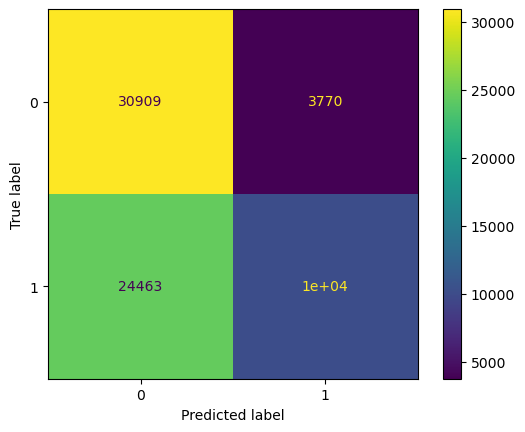

In [21]:
test_cross_validation(3)

### Test cross validation with 5 cuts

accuracy -> 59.23%
precision -> 72.8%
recall -> 29.53%
f1_score -> 41.94%



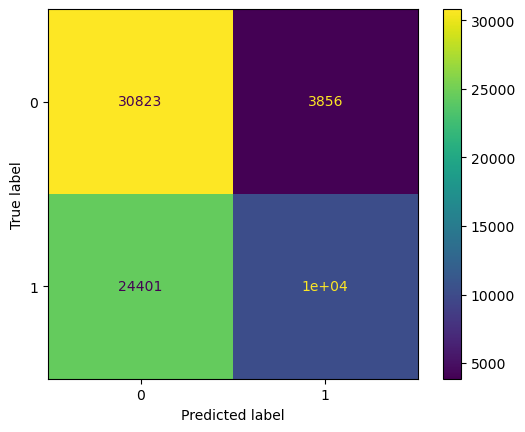

In [22]:
test_cross_validation(5)

### Test cross validation with 7 cuts

accuracy -> 59.06%
precision -> 72.22%
recall -> 29.31%
f1_score -> 41.69%



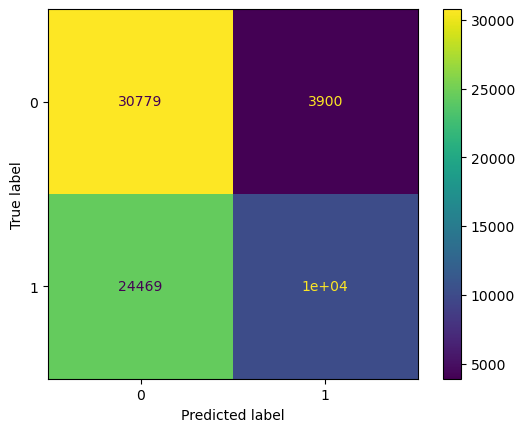

In [23]:
test_cross_validation(7)

### Test cross validation with 9 cuts

accuracy -> 59.02%
precision -> 72.15%
recall -> 29.27%
f1_score -> 41.64%



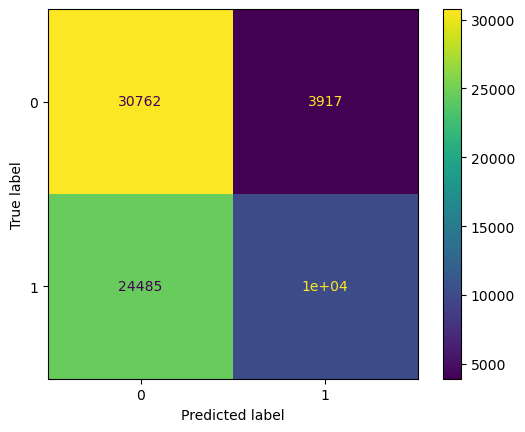

In [24]:
test_cross_validation(9)

### Najlepsza liczba podziału `cuts`
W przypadku naszego problemu - wykrywanie choroby serca, bardziej zależy nam na pełności niż na precyzji, gdyż  
chcemy zaminimalizować liczbę sytuacji, w których nie wykryjemy choroby serca u chorego pacjenta. W związku z tym,  
ostatecznie dobrano wartość parametru `cuts = 5`, ponieważ posiada on największą pełność, a także nie odstaje zbytnio od pozostałych parametrów resztą metryk. 

In [26]:
test_metrics(0.9, 0.05)
test_metrics(0.8, 0.1)
test_metrics(0.8, 0.15)
test_metrics(0.7, 0.15)
test_metrics(0.6, 0.2)
test_metrics(0.6, 0.1)
test_metrics(0.5, 0.25)

TRAIN - 0.9 && VALID - 0.05 && TEST - 0.05
accuracy -> 58.76%
precision -> 69.37%
recall -> 30.29%
f1_score -> 42.17%

TRAIN - 0.8 && VALID - 0.1 && TEST - 0.1
accuracy -> 58.21%
precision -> 72.34%
recall -> 26.82%
f1_score -> 39.13%

TRAIN - 0.8 && VALID - 0.15 && TEST - 0.05
accuracy -> 58.47%
precision -> 72.09%
recall -> 26.84%
f1_score -> 39.12%

TRAIN - 0.7 && VALID - 0.15 && TEST - 0.15
accuracy -> 58.46%
precision -> 72.18%
recall -> 27.47%
f1_score -> 39.79%

TRAIN - 0.6 && VALID - 0.2 && TEST - 0.2
accuracy -> 57.63%
precision -> 73.06%
recall -> 25.16%
f1_score -> 37.43%

TRAIN - 0.6 && VALID - 0.1 && TEST - 0.3
accuracy -> 57.58%
precision -> 73.42%
recall -> 25.49%
f1_score -> 37.84%

TRAIN - 0.5 && VALID - 0.25 && TEST - 0.25
accuracy -> 57.71%
precision -> 71.38%
recall -> 25.84%
f1_score -> 37.95%



### Wyniki
Jeśli chodzi o metodę pomiaru zbiorem walidacyjnym to najlepiej wypdał podział `0.9 : 0.05 : 0.05` z `accuracy = 58.76%` i `recall = 30.29%`. Natomiast metoda k-krotnej walidacji najlepiej sprawdziła się dla `cuts = 5` z `accuracy = 59.23%` i `recall = 29.53%`

### Wnioski ogólne
Skuteczność modelu naiwnego klasyfikatora Bayesa zależy od wielu czynników:  
- samych danych,  
- sposobie podziału zbioru danych na podzbiory treningowy, walidacyjny, testowy,  
- rozmiaru danych wejściowych - im więcej danych tym dokładniejszy model otrzymamy,  
- wadą jest powolna klasyfikacja nowych danych na podstawie już raz wyliczonego modelu.

Klasyfikator Bayesa nie działa dobrze na tym zbiorze danych, ponieważ prawdopodobnie kolumny (cechy) w zbiorze danych są od siebie w jakiś znaczący sposób zależne np. `height` od `gender`, a podstawowym założeniem naiwnego klasyfikatora Bayesa jest to, że owe kolumny są od siebie niezależne.